In [1]:
# Import Necessary Packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

import os
import sys
sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
#from plotting_functions import *
#from utils import *

import altair as alt
from vega_datasets import data
# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

pd.set_option("display.max_colwidth", 200)

# kNN

# Example 1: Canada USA Cities

In [2]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

In [3]:
city_plot = alt.Chart(cities_df).mark_point(size = 150, filled = True).encode(
    x = alt.X('longitude:Q', scale = alt.Scale(zero = False)),
    y = alt.Y('latitude:Q', scale = alt.Scale(zero = False)),
    color = alt.Color('country:N'),
    shape = 'country:N'
).properties(
    height = 300,
    width = 400
)
city_plot

alt.Chart(...)

In [4]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_cities, y_cities, test_size = 0.1, random_state = 123
)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

k = 1
knn1 = KNeighborsClassifier(n_neighbors = k)
scores = cross_validate(knn1, X_train, y_train, return_train_score = True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000805,0.000985,0.710526,1.0
1,0.000454,0.000626,0.684211,1.0
2,0.000414,0.000595,0.842105,1.0
3,0.000414,0.000596,0.702703,1.0
4,0.000404,0.000578,0.837838,1.0


In [6]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors = k)
scores = cross_validate(knn100, X_train, y_train, return_train_score = True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000638,0.035554,0.605263,0.600000
1,0.000534,0.001190,0.605263,0.600000
2,0.000443,0.001100,0.605263,0.600000
3,0.000414,0.001044,0.594595,0.602649
4,0.000391,0.001076,0.594595,0.602649


### Hyperparameter k Value
- choose the best k n_neighbors with the best test scores

In [7]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_train_score": [],
    "std_cv_score": []
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)} # In practice, better choose odd numbers so there wouldn't be equal neighbors lead to indecisive

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn, X_train, y_train, return_train_score = True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict).set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_train_score,std_cv_score
n_neighbors,,,,
1,1.000000,0.755477,0.000000,0.069530
6,0.831135,0.792603,0.013433,0.046020
11,0.819152,0.802987,0.011336,0.041129
16,0.801863,0.782219,0.008735,0.074141
21,0.777934,0.766430,0.016944,0.062792
26,0.755364,0.723613,0.025910,0.061937
31,0.743391,0.707681,0.030408,0.057646
36,0.728777,0.707681,0.021305,0.064452
41,0.706128,0.681223,0.018310,0.061241


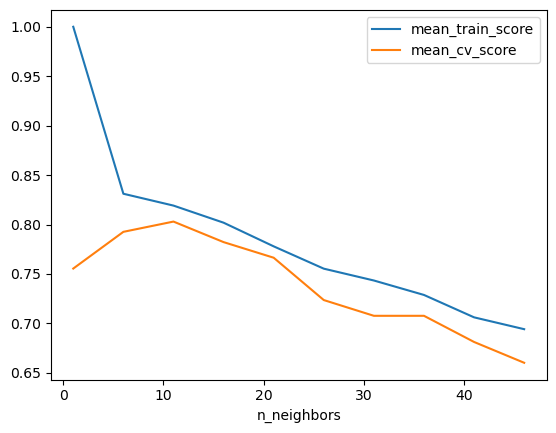

In [8]:
results_df[["mean_train_score", "mean_cv_score"]].plot();

In [9]:
best_n_neighbours = results_df.idxmax()["mean_cv_score"]
best_n_neighbours

np.int64(11)

In [10]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbours)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

Test accuracy: 0.905


# Pros and Cons of kNN

### Pros
- Easy to understand, interpret.
- Simple hyperparameter (n_neighbors) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to fit
- Versatile: can be used for both classification (by taking a majority vote) and regression (by taking the average value of the neighbors).

### Cons
- Can be potentially be VERY slow during prediction time, especially when the training set is very large.
- Often not that great test accuracy compared to the modern approaches.
- The Curse of Dimensionality: It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).
- Requires feature scaling: the algorithm is based on distance, so it is critical that all features are on the same scale.
- High memory usage:
- Sensitive to the choice of k: small k is sensitive to noise and outliers (high variance, prone to overfitting), large k oversmooths the decision boundary and may miss local patterns (high bias, prone to underfitting).

### Verdict
It is also a good baseline model.

# SVM RBF

# Example 1: Canada USA Cities

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cities, y_cities, test_size=0.2, random_state=123
)

In [12]:
# Repeat KNN Example

knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
scores = cross_validate(knn, X_train, y_train, return_train_score = True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.803


,fit_time,score_time,test_score,train_score
0,0.000662,0.001510,0.794118,0.819549
1,0.000884,0.001166,0.764706,0.819549
2,0.000600,0.000784,0.727273,0.850746
3,0.000439,0.000678,0.787879,0.828358
4,0.000414,0.000626,0.939394,0.783582


In [13]:
# SVM with RBF kernal, we can think of it as "smooth KNN"
from sklearn.svm import SVC

svm = SVC(gamma = 0.01)  # Ignore gamma for now
scores = cross_validate(svm, X_train, y_train, return_train_score = True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.820


,fit_time,score_time,test_score,train_score
0,0.000906,0.000644,0.823529,0.842105
1,0.001103,0.000522,0.823529,0.842105
2,0.000657,0.000489,0.727273,0.858209
3,0.000750,0.000530,0.787879,0.843284
4,0.000696,0.000442,0.939394,0.805970


In [14]:
scores

{'fit_time': array([0.00090599, 0.00110269, 0.00065684, 0.00074983, 0.00069618]),
 'score_time': array([0.00064421, 0.00052238, 0.000489  , 0.00053024, 0.00044179]),
 'test_score': array([0.82352941, 0.82352941, 0.72727273, 0.78787879, 0.93939394]),
 'train_score': array([0.84210526, 0.84210526, 0.85820896, 0.84328358, 0.80597015])}

# Hyperparameters: gamma and C

### gamma
- larger gamma -> more complex
- smaller gamma -> less complex

### C
- larger C -> more complex
- smaller C -> less complex

# Example 2: Census data, compare KNN, SVM RBF, Decision Tree

In [15]:
# Read DF and Run EDA
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

In [16]:
train_df, test_df = train_test_split(census_df, train_size = 0.4, test_size = 0.6, random_state = 123)

In [17]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [18]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape

(13024, 15)

In [19]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [20]:
census_summary = train_df.describe(include="all")
census_summary

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,13024.000000,12284,1.302400e+04,13024,13024.000000,13024,12281,13024,13024,13024,13024.000000,13024.000000,13024.000000,12783,13024
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,9123,NaN,4153,NaN,5936,1649,5195,11158,8700,NaN,NaN,NaN,11717,9875
mean,38.546913,NaN,1.884759e+05,NaN,10.057432,NaN,NaN,NaN,NaN,NaN,1079.831695,86.543074,40.395654,NaN,NaN
std,13.610225,NaN,1.040895e+05,NaN,2.553084,NaN,NaN,NaN,NaN,NaN,7322.034546,403.025863,12.285347,NaN,NaN
min,17.000000,NaN,1.376900e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.170962e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778990e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.365655e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [21]:
max_hours_per_week = census_df["hours.per.week"].max()
max_hours_per_week

np.int64(99)

In [22]:
most_freq_occupation = census_df["occupation"].mode()[0] # 1.2.2
most_freq_occupation

'Prof-specialty'

In [23]:
census_df.isnull()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32557,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32558,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32559,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [24]:
missing_vals_cols = train_df.columns[train_df.isna().any()].tolist() # 1.2.3
numeric_cols = train_df.select_dtypes(include = 'number').columns.tolist() # 1.2.4
missing_vals_cols

['workclass', 'occupation', 'native.country']

In [25]:
numeric_cols

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

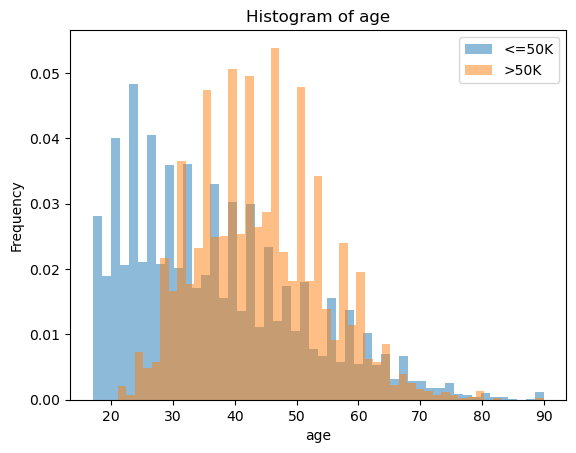

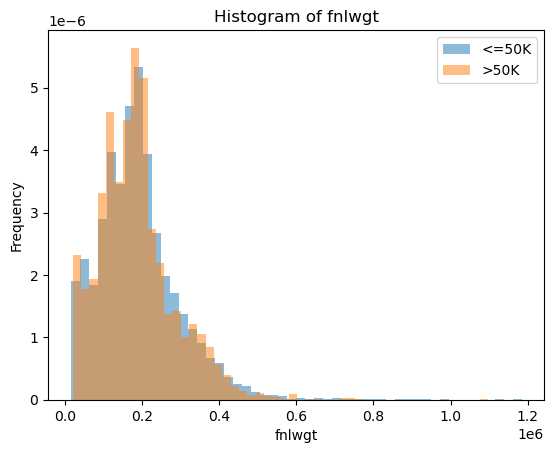

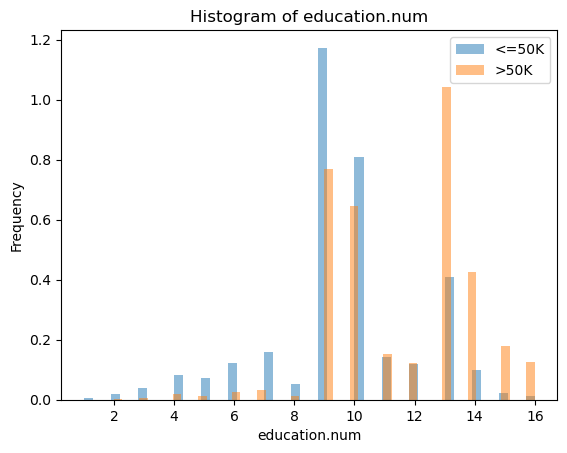

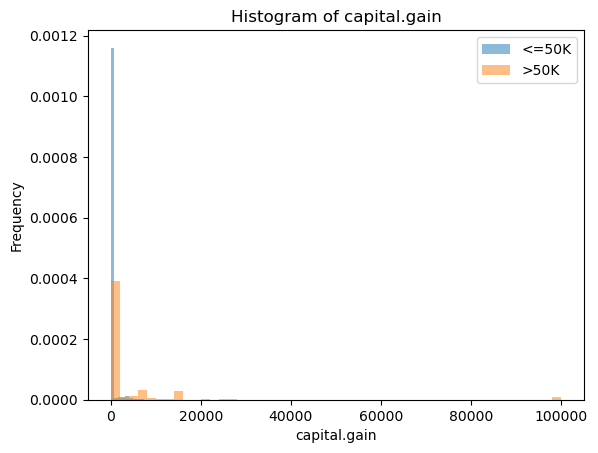

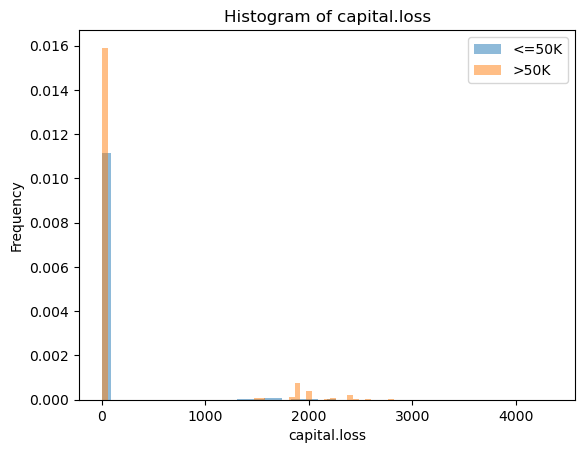

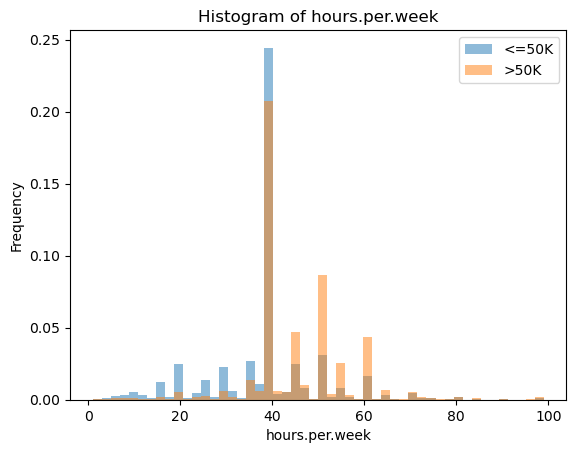

In [26]:
for f in numeric_cols:
    train_df.groupby("income")[f].plot.hist(bins = 50, alpha = 0.5, legend = True, density = True, title = "Histogram of " + f)
    plt.xlabel(f)
    plt.show()

### Prepare Feature Transform: Imputation, Scaling, ...etc

In [27]:
# Identify Feature Types for later use
numeric_features = ["age","capital.gain","capital.loss","hours.per.week"]
categorical_features = ["workclass","marital.status","occupation","relationship","native.country"]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt","education.num","race"]	
target = "income"

In [28]:
# Split Data
X_train = train_df.drop(columns=["income"])
y_train = train_df["income"]

X_test = test_df.drop(columns=["income"])
y_test = test_df["income"]

In [29]:
# Creat Dummy
dummy_clf = DummyClassifier(random_state = 571)
dummy_df = pd.DataFrame(cross_validate(dummy_clf, X_train, y_train, cv = 5, return_train_score = True))
dummy_df

,fit_time,score_time,test_score,train_score
0,0.002448,0.001283,0.758157,0.758230
1,0.002416,0.001213,0.758157,0.758230
2,0.002260,0.001124,0.758157,0.758230
3,0.002252,0.001113,0.758157,0.758230
4,0.002234,0.001129,0.758449,0.758157


In [30]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

numeric_transformer = StandardScaler()

In [31]:
# Ordinal Encoding
from sklearn.preprocessing import OrdinalEncoder

edu_order = ["Preschool",
             "1st-4th",
             "5th-6th",
             "7th-8th",
             "9th",
             "10th",
             "11th",
             "12th",
             "HS-grad", 
             "Prof-school", 
             "Assoc-voc", 
             "Assoc-acdm", 
             "Some-college", 
             "Bachelors",
             "Masters",
             "Doctorate"
            ]
ordinal_transformer = OrdinalEncoder(categories = [edu_order], dtype = int)

In [32]:
# Binary Encoding
from sklearn.preprocessing import OneHotEncoder

binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)

In [33]:
# OneHotEncoding (OHE) and Simple Imputer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Create the pipeline for categorical feature transformer
categorical_transformer = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = "missing"),
    OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
)

In [34]:
# Preparing Column Transform by creating preprocessor using the make_column_transformer() function
# Note: the fit at this stage is only transform fit, not training fit
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [35]:
# Note: the fit at this stage is only transform fit, not training fit
# When creating and using pipeline, we don't need to manually run fit and transform like we do here

transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train))
n_new_cols = transformed_df.shape[1] - X_train.shape[1]
transformed_df

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.921909,-0.147483,-0.214742,0.781802,13.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.436248,-0.147483,-0.214742,-2.148630,12.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.848432,-0.147483,-0.214742,-0.032207,6.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.768061,-0.147483,-0.214742,-0.032207,12.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.436248,-0.147483,-0.214742,-0.439211,8.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13019,0.694584,-0.147483,-0.214742,0.781802,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13020,-0.260617,-0.147483,-0.214742,-0.195008,5.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13021,-0.921909,-0.147483,-0.214742,0.130595,12.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13022,-0.774955,-0.147483,-0.214742,-0.032207,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Number of New Columns created after transform
n_new_cols

70

### Build Models

In [37]:
# Functions to conclude scores between models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data = out_col, index = mean_scores.index)

In [38]:
results_dict = {}  # dictionary to store all the results

In [39]:
# Baseline Dummy Model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy) # create pipeline to run preprocessor first then the model
results_dict["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, cv = 5, return_train_score = True)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.004 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)


In [40]:
# Other Models

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "decision tree": DecisionTreeClassifier(random_state = 123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state = 123),
}

In [41]:
models

{'decision tree': DecisionTreeClassifier(random_state=123),
 'kNN': KNeighborsClassifier(),
 'RBF SVM': SVC(random_state=123)}

In [42]:
# Train and Cross-Validate

for n, m in models.items():
    pipe = make_pipeline(preprocessor, m)
    results_dict[n] = mean_std_cross_val_scores(pipe, X_train, y_train, cv = 5, return_train_score = True)
income_pred_results_df = pd.DataFrame(results_dict).T
income_pred_results_df

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.004 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.043 (+/- 0.001),0.005 (+/- 0.000),0.817 (+/- 0.008),0.987 (+/- 0.001)
kNN,0.015 (+/- 0.000),0.037 (+/- 0.002),0.836 (+/- 0.009),0.884 (+/- 0.002)
RBF SVM,1.288 (+/- 0.058),0.652 (+/- 0.051),0.852 (+/- 0.005),0.855 (+/- 0.002)


### Hyperparameter Optimization

In [43]:
# Very basic method to find the best C
param_grid = {
    "C": [0.1, 100, 1000]
}
param_grid

{'C': [0.1, 100, 1000]}

In [44]:
svc_results_dict = {}

for c in param_grid["C"]:
    model = SVC(C = c, random_state = 123)
    pipe = make_pipeline(preprocessor, model)
    svc_results_dict[f"RBF SVM (C = {c})"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv = 5, return_train_score = True
    )

svc_results_df = pd.DataFrame(svc_results_dict).T
svc_results_df

,fit_time,score_time,test_score,train_score
RBF SVM (C = 0.1),1.492 (+/- 0.067),0.757 (+/- 0.012),0.838 (+/- 0.006),0.838 (+/- 0.002)
RBF SVM (C = 100),1.612 (+/- 0.021),0.577 (+/- 0.008),0.860 (+/- 0.006),0.871 (+/- 0.002)
RBF SVM (C = 1000),3.242 (+/- 0.134),0.567 (+/- 0.015),0.855 (+/- 0.006),0.884 (+/- 0.002)


In [45]:
best_C = 100

In [46]:
# Finalize parameters
best_svm_model = SVC(C = best_C, random_state = 123)
final_pipeline = make_pipeline(preprocessor, best_svm_model)

# Train
final_pipeline.fit(X_train, y_train)

# Score
test_score = final_pipeline.score(X_test, y_test)
test_score

0.8497722270563546

# Pros and Cons of SVM RBF Model

### Pros:
- ***Excellent at non-linear data:*** This is its superpower. While a standard Linear SVM (or Logistic Regression) can only draw a straight line, the RBF kernel can draw circles, blobs, and complex curvy shapes to separate classes. It does this by mathematically mapping your data into a higher-dimensional space where the separation becomes easier.
- ***Effective in high-dimensional spaces (many features/columns):*** SVMs work surprisingly well even when you have more features (columns) than you have data points (rows). This makes them popular in fields like genetics (thousands of genes, few patients) or text classification.
- ***Robust to overfitting if tunned:*** Because SVMs maximize the margin (the distance between the decision boundary and the nearest data points), they tend to generalize well to new data, provided you tune the Regularization parameter C correctly.
- ***Ignores outliers:*** The decision boundary is determined only by the "Support Vectors"—the specific data points closest to the boundary. Points that are far away (easy to classify) have zero influence on the model. This makes the model stable against noise in the "easy" parts of the data.

### Cons:
- ***Not suitable for large datasets (many rows):*** This is the biggest deal-breaker. The training time complexity is roughly quadratic to cubic ($O(n^2)$ to $O(n^3)$). If you have 100,000+ rows of data, an SVM might take hours or days to train, whereas a Random Forest might take minutes.
- ***Requires Feature Scaling (Crucial):*** SVMs are distance-based models. If you do not scale your data (using StandardScaler), the model will be completely broken. A feature with a range of 0–1000 will dominate a feature with a range of 0–1. (Unlike Decision Trees, which don't care about scaling).
- ***Hard to Interpret (Black Box):*** Unlike a Decision Tree, you cannot look at an SVM and say "It predicted True because Age > 30." The model is a complex mathematical combination of vectors in a high-dimensional space. It is very difficult to explain the "why" behind a prediction to a non-technical stakeholder.
- ***Sensitive to Hyperparameters:*** As we discussed, performance relies heavily on finding the exact right balance of C and gamma. You almost always need to run a computationally expensive GridSearchCV to get good results.
- ***No Probability Estimates:*** SVMs output a class label directly, not a probability (like 85% chance of "Yes"). To get probabilities, you have to enable a special setting (probability=True in sklearn), which uses a technique called Platt scaling. This slows down the training by 5x to 10x.

### The Verdict:
***Use SVM (RBF) when:***

- You have a small to medium-sized dataset (e.g., < 50,000 rows).
- You care about accuracy more than interpretability.
- Your data has complex, non-linear relationships.
- You have many features (high dimensionality).

***Avoid SVM (RBF) when:***

- You have a massive dataset (use Deep Learning or Histogram-based Gradient Boosting instead).
- You need to explain exactly why a decision was made (use Decision Trees or Logistic Regression).
- You cannot afford the time to scale your data or tune hyperparameters.

# Example 3: Bag of Word (CountVectorizer) Comparison

In [47]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [48]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


In [49]:
# Simple EDA
train_df["length"] = train_df["sms"].str.len()

# Compute summary stats by class

summary = (
    train_df.groupby("target")["length"]
    .agg(["mean", "min", "max"])
    .rename(columns={"mean": "avg_len", "min": "shortest_len", "max": "longest_len"})
)

summary

,avg_len,shortest_len,longest_len
target,,,
ham,70.957845,2,790
spam,138.657980,13,224


In [50]:
# Check the shortest and longest spam/ham messages
for label in ["spam", "ham"]:
    subset = train_df[train_df["target"] == label]
    shortest_msg = subset.loc[subset["length"].idxmin(), "sms"]
    longest_msg = subset.loc[subset["length"].idxmax(), "sms"]
    print(f"\n {label.upper()} MESSAGES")
    print(f"Shortest ({summary.loc[label, 'shortest_len']} chars): {shortest_msg}")
    print(f"Longest  ({summary.loc[label, 'longest_len']} chars): {longest_msg}")


 SPAM MESSAGES
Shortest (13 chars): 2/2 146tf150p
Longest  (224 chars): Hi, this is Mandy Sullivan calling from HOTMIX FM...you are chosen to receive å£5000.00 in our Easter Prize draw.....Please telephone 09041940223 to claim before 29/03/05 or your prize will be transferred to someone else....

 HAM MESSAGES
Shortest (2 chars): Ok
Longest  (790 chars): The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarasse

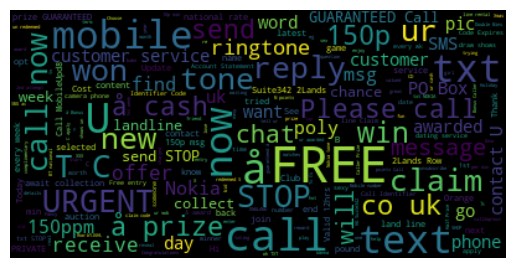

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_text = " ".join(train_df[train_df['target'] == 'spam']['sms'].astype(str))
#wordcloud = WordCloud().generate(spam_text)
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(spam_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

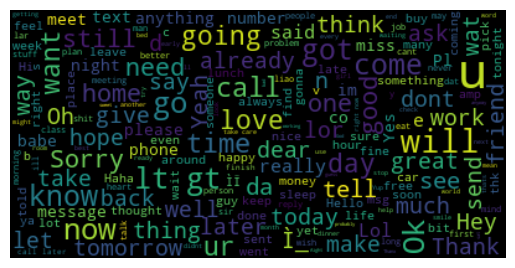

In [52]:
ham_text = " ".join(train_df[train_df['target'] == 'ham']['sms'].astype(str))

#wordcloud = WordCloud().generate(ham_text)
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(ham_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
# Split X, y

X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]

In [54]:
X_train.shape

(4457,)

In [55]:
# Dummy

dummy = DummyClassifier()
dummy_scores = cross_val_score(dummy, X_train, y_train)
dummy_scores

array([0.86210762, 0.86210762, 0.8630752 , 0.86195286, 0.86195286])

In [56]:
dummy_scores.mean()

np.float64(0.862239233390205)

In [57]:
train_df["target"].value_counts()

target
ham     3843
spam     614
Name: count, dtype: int64

### CountVectorizer
Bag of Word method in comparison with OneHot Encoding

### The Main Difference: "Whole String" vs. "Tokens"
The most critical distinction is how they treat a string of text.

- OneHotEncoder looks at the entire string as a single, atomic label. It does not look inside the string.

    - Input: "New York"

    - OHE sees: 1 category called "New York".

- CountVectorizer breaks the string apart (tokenization). It looks for individual words.

    - Input: "New York"

    - CV sees: 2 words: "New" and "York".

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(X_train)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [59]:
vocab = cv.get_feature_names_out()
vocab.shape

(7682,)

In [60]:
vocab[:10]  # First 10 words

array(['00', '000', '000pes', '008704050406', '0089', '0121',
       '01223585236', '01223585334', '0125698789', '02'], dtype=object)

In [61]:
vocab[0::100]  # Every 100th word

array(['00', '08712101358', '09061701851', '12mths', '2find', '440',
       '69911', '86888', 'accommodationvouchers', 'aint', 'answerin',
       'asa', 'b4190604', 'become', 'bleak', 'brainy', 'buzz', 'causing',
       'chinese', 'colleagues', 'converter', 'cttargg', 'deduct',
       'different', 'donyt', 'eastenders', 'entitled', 'expected',
       'feellikw', 'flowing', 'frnt', 'george', 'gower', 'hand', 'here',
       'hotmix', 'ill', 'interesting', 'jaykwon', 'kath', 'lamp', 'lido',
       'loosing', 'madoke', 'mcr', 'miserable', 'movie', 'nattil',
       'nooooooo', 'okies', 'overa', 'payments', 'placed', 'postal',
       'problem', 'quoting', 'recovery', 'restocked', 'runs',
       'scrumptious', 'shaking', 'signing', 'sms', 'sparkling',
       'statements', 'submitted', 'sweater', 'telly', 'those', 'tonite',
       'tuesday', 'unrecognized', 'very', 'wallpaper', 'wewa', 'women',
       'yay'], dtype=object)

In [62]:
vocab[7600:]  # Last 82 words

array(['yay', 'yeah', 'year', 'years', 'yeh', 'yelling', 'yellow',
       'yelow', 'yen', 'yeovil', 'yep', 'yer', 'yes', 'yest', 'yesterday',
       'yet', 'yetty', 'yetunde', 'yi', 'yijue', 'ym', 'ymca', 'yo',
       'yoga', 'yogasana', 'yor', 'you', 'youdoing', 'youi', 'young',
       'younger', 'youphone', 'your', 'youre', 'yourjob', 'yours',
       'yourself', 'youuuuu', 'youwanna', 'youåõre', 'yoville', 'yowifes',
       'yoyyooo', 'yr', 'yrs', 'ystrday', 'ything', 'yummmm', 'yummy',
       'yun', 'yunny', 'yuo', 'yuou', 'yup', 'yupz', 'zac', 'zaher',
       'zealand', 'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zogtorius',
       'zoom', 'zyada', 'åè10', 'åð', 'åòharry', 'åòit', 'åômorrow',
       'åôrents', 'ì_', 'ì¼1', 'ìï', 'û_', 'û_thanks', 'ûªm', 'ûªt',
       'ûªve', 'ûò', 'ûówell'], dtype=object)

### SVC

In [63]:
svc_pipe = make_pipeline(CountVectorizer(stop_words = 'english'), SVC(random_state = 123))
mean_cv_svc = cross_val_score(svc_pipe, X_train, y_train).mean()
mean_cv_svc

np.float64(0.9771126813727712)

In [64]:
pd.DataFrame(cross_validate(svc_pipe, X_train, y_train))

,fit_time,score_time,test_score
0,0.259003,0.057614,0.977578
1,0.255163,0.056752,0.985426
2,0.254965,0.055194,0.968575
3,0.252062,0.056458,0.978676
4,0.256253,0.058097,0.975309


In [65]:
# Fit the pipeline so we can access its individual steps
svc_pipe.fit(X_train, y_train)

,steps,"[('countvectorizer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [66]:
# Extract the fitted CountVectorizer and SVC objects from the pipeline which you should be using in this exercise.
countvec_obj = svc_pipe["countvectorizer"]
svc_obj = svc_pipe["svc"]

In [67]:
# Manually Compute the Validation Score for SVC Model on the first fold

# Split
X_train_fold, X_validate_fold, y_train_fold, y_validate_fold = train_test_split(X_train, y_train, train_size = 0.8, shuffle = False)

# CountVectorizer Fit + Transform on Cross Validate Train data
X_train_fold_countvect = countvec_obj.fit_transform(X_train_fold)
# CountVectorizer Transform ONLY on Cross Validate Validation data
X_validate_fold_countvect = countvec_obj.transform(X_validate_fold)

# SVC Fit on CountVectorized X_train and y_train data
svc_manual = svc_obj
svc_manual.fit(X_train_fold_countvect, y_train_fold)

# SVC score on CountVectorized X_validate and y_validate data
fold_score = svc_manual.score(X_validate_fold_countvect, y_validate_fold)
fold_score

0.9753363228699552

### Only Optimize C using GridSearchCV()

In [68]:
param_grid = {"svc__C": 10.0 ** np.arange(-2, 3)}

In [69]:
def plot_train_cv(param_vals, train_scores, cv_scores, xlabel, ylabel="accuracy"):
    plt.semilogx(param_vals, train_scores, label="train")
    plt.semilogx(param_vals, cv_scores, label="valid")
    plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [70]:
print(
    "We are carrying out %d 5-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

C_search = GridSearchCV(svc_pipe, param_grid, n_jobs=-1, cv=5, return_train_score=True)
C_search.fit(X_train, y_train)

We are carrying out 5 5-fold cross-validation experiments


,estimator,Pipeline(step..._state=123))])
,param_grid,"{'svc__C': array([1.e-02...e+01, 1.e+02])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,input,'content'


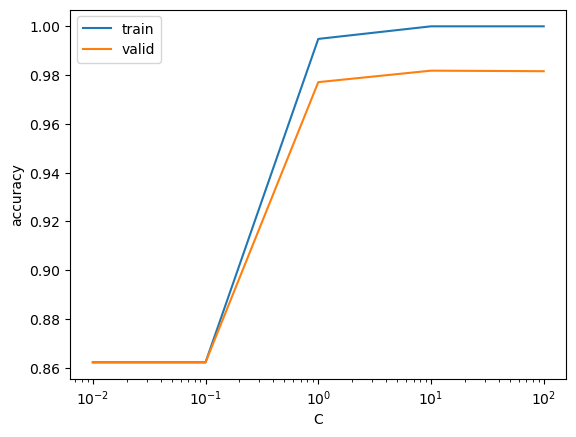

In [71]:
train_scores = C_search.cv_results_["mean_train_score"]
cv_scores = C_search.cv_results_["mean_test_score"]
plot_train_cv(param_grid["svc__C"], train_scores, cv_scores, xlabel="C")

In [72]:
# identify best C
best_C = C_search.best_params_["svc__C"]
best_C_score = C_search.best_score_
print("Best hyperparameter values: %0.4f" % (best_C))
print("Best score: %0.8f" % (best_C_score))

Best hyperparameter values: 10.0000
Best score: 0.98182422


### Optimize C and gamma using GridSearchCV()
- best_params_ and best_score_ come from GridSearchCV() or RandomizedSearchCV(): https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [73]:
param_grid = {
    "svc__C": 10.0 ** np.arange(-2, 3),
    "svc__gamma": 10.00 ** np.arange(-2, 3)
}  # Parameter grid for grid search

gamma_C_search = GridSearchCV(svc_pipe, param_grid = param_grid, n_jobs = -1, cv = 5, return_train_score = True) # Grid search object
gamma_C_search.fit(X_train, y_train)

best_gamma_C = gamma_C_search.best_params_  # Best hyperparameter values (dictionary)
best_gamma_C_score = gamma_C_search.best_score_  # Mean CV score with best hyperparameters

print("Best hyperparameter values: ", best_gamma_C)
print("Best score: %0.8f" % best_gamma_C_score)

Best hyperparameter values:  {'svc__C': np.float64(10.0), 'svc__gamma': np.float64(0.1)}
Best score: 0.98204844


### Optimize C and gamma using RandomizedSearchCV()
- best_params_ and best_score_ come from GridSearchCV() or RandomizedSearchCV(): https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [74]:
from random import randint, uniform
from scipy.stats import loguniform
param_dist = {
    "countvectorizer__max_features": np.arange(900,1501,50),
    "svc__C": np.arange(0.01, 20, 0.01),
    "svc__gamma": np.arange(0.001, 10, 0.001)
}

In [75]:
random_search = RandomizedSearchCV(svc_pipe, param_distributions = param_dist, n_iter = 200, n_jobs = -1, return_train_score = True, random_state = 571)
random_search.fit(X_train, y_train)

,estimator,Pipeline(step..._state=123))])
,param_distributions,"{'countvectorizer__max_features': array([ 900, ... 1450, 1500]), 'svc__C': array([1.000e...shape=(1999,)), 'svc__gamma': array([1.000e...shape=(9999,))}"
,n_iter,200
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,571
,error_score,nan


In [76]:
# Get Best Parameter Value and Best Score
random_search_best_params = random_search.best_params_
random_search_best_score = random_search.best_score_
random_search_best_params

{'svc__gamma': np.float64(0.107),
 'svc__C': np.float64(5.34),
 'countvectorizer__max_features': np.int64(1250)}

In [77]:
print("Best Random Search score: %0.8f" % random_search_best_score)

Best Random Search score: 0.98406864


In [78]:
best_cv_score = random_search_best_score
train_score = random_search.score(X_train, y_train)
test_score = random_search.score(X_test, y_test)

print("CV score: %0.8f" % best_cv_score)
print("Train score: %0.8f" % train_score)
print("Test score: %0.8f" % test_score)

CV score: 0.98406864
Train score: 0.99775634
Test score: 0.98475336


### Test sample messages

In [79]:
sample_text_msgs = [
    """Call 8375467843 immediately. URGENT!! 
                    You have a free gift waiting for you...""",  # potential spam
    "MDS is fun.",  # potential non-spam
    """This is very URGENT!! This week the MDS team has decided that 
                      all of you get 100% on all assignments and quizzes for free. 
                      Visit https://bit.ly/2T15k6V to check your grades.""",  # potential spam
]

In [80]:
prediction = random_search.predict(sample_text_msgs)
prediction

array(['spam', 'ham', 'spam'], dtype=object)